In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import lastfm
from movielens import movielens
from sklearn.metrics import roc_auc_score
from scipy.sparse.linalg import eigsh
import utils
from tqdm import tqdm

In [2]:
colors = ["#1b9e77",
          "#d95f02",
          "#7570b3",
          "#e7298a"
         ]

In [46]:
def get_movielens():
    movielens_obj = movielens(top_k_users = 2000, top_k_items = 1000, binary = False)
    idx_to_genres = movielens_obj.get_genres()
    X = movielens_obj.get_X()
    assert X.shape[1] == len(idx_to_genres)

    genres_to_idx = {}
    for idx in idx_to_genres:
        for genre in idx_to_genres[idx]:
            if genre not in genres_to_idx:
                genres_to_idx[genre] = []
            genres_to_idx[genre].append(idx)

    column_sample = []
    for genre in genres_to_idx:
        idxs = np.array(genres_to_idx[genre])
        top_idx = np.argsort(np.sum(X[:, idxs] != 0, axis = 0))[-30:]
        new_column_sample = column_sample.copy()
        for idx in idxs[top_idx]:
            if idx not in column_sample:
                new_column_sample.append(idx)
        column_sample = new_column_sample

    X = X[:, column_sample]

    X_top_movies = np.zeros(X.shape)
    for i in range(len(X)):
        top_movie_idxs = np.argsort(X[i])[-30:]
        X_top_movies[i, top_movie_idxs] = X[i, top_movie_idxs]
    
    X_binary = np.zeros(X.shape)
    X_binary[X_top_movies == 1] = -2
    X_binary[X_top_movies == 2] = -1
    X_binary[X_top_movies == 3] = 1
    X_binary[X_top_movies == 4] = 2
    X_binary[X_top_movies == 5] = 3

    return X_binary / 100

def get_lastfm():
    lastfm_obj = lastfm.lastfm(data_dir = "data/lastfm/")
    P = lastfm_obj.filter(min_users = 50, min_ratings = 20)

    P = np.linalg.inv(np.diag(np.sum(P, axis=1))) @ P
    assert np.allclose(np.sum(P, axis=1), np.ones(len(P)))
    return P

#LASTFM
# P = get_lastfm()
# with open("pickles/max_pred_movielens_all_cosine.pickle", "rb") as pickleFile:
#     description, train_idxs, proj_matrices_max_pred = pickle.load(pickleFile)

# low_artist_filter = np.sum(P > 0, axis = 0) < 50
# med_artist_filter = (np.sum(P > 0, axis = 0) >= 50) & (np.sum(P > 0, axis = 0) <= 150)
# high_artist_filter = np.sum(P > 0, axis = 0) > 150
# assert np.all((low_artist_filter | med_artist_filter) | high_artist_filter)
# assert np.sum(low_artist_filter) + np.sum(med_artist_filter) + np.sum(high_artist_filter) == P.shape[1]

#MOVIELENS
P = get_movielens()
with open("pickles/max_pred_movielens_all_cosine.pickle", "rb") as pickleFile:
    description, train_idxs, proj_matrices_max_pred = pickle.load(pickleFile)

low_artist_filter = np.sum(P > 0, axis = 0) < 100
med_artist_filter = (np.sum(P > 0, axis = 0) >= 100) & (np.sum(P > 0, axis = 0) <= 225)
high_artist_filter = np.sum(P > 0, axis = 0) > 225
assert np.all((low_artist_filter | med_artist_filter) | high_artist_filter)
assert np.sum(low_artist_filter) + np.sum(med_artist_filter) + np.sum(high_artist_filter) == P.shape[1]

test_idxs = train_idxs

0.36575082231674577


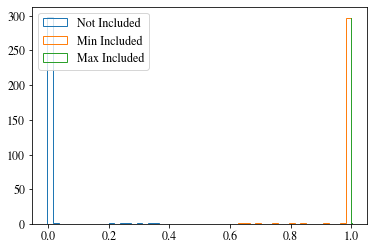

In [30]:
min_eigenvalues = []
min_actual = []
max_actual = []

max_r = P.shape[1]
for r in range(1, max_r - 1):
    w, v = eigsh(proj_matrices_max_pred[r], which = "LM", k = r + 1)
    w = np.sort(w)
    min_eigenvalues.append(w[0])
    min_actual.append(w[1])
    max_actual.append(w[-1])
print(max(min_eigenvalues))
fig, ax = plt.subplots()
ax.hist(min_eigenvalues, bins = 20, histtype = "step", label = "Not Included")
ax.hist(min_actual, bins = 20, histtype = "step", label = "Min Included")
ax.hist(max_actual, bins = 20, histtype = "step", label = "Max Included")
ax.legend()

Num Low Popular: 105
Num Medium Popular: 112
Num High Popular: 91


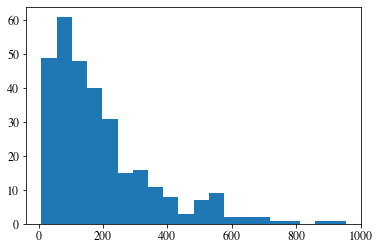

In [32]:
plt.hist(np.sum(P  > 0, axis = 0), bins = 20)
print("Num Low Popular: {}".format(np.sum(low_artist_filter)))
print("Num Medium Popular: {}".format(np.sum(med_artist_filter)))
print("Num High Popular: {}".format(np.sum(high_artist_filter)))

## Figures 3 and 4

In [33]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family = "Nimbus Roman")          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


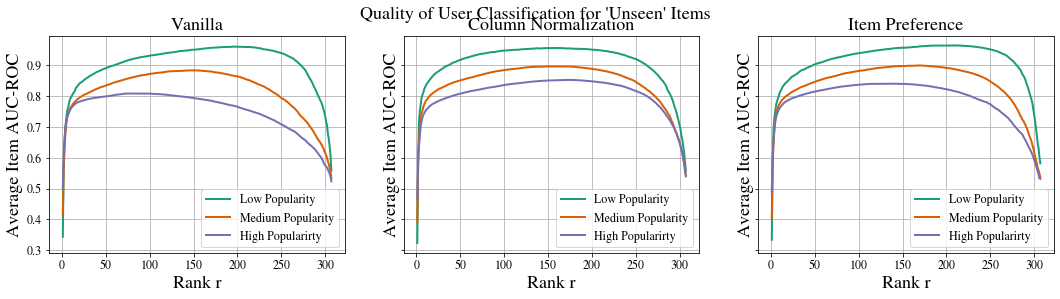

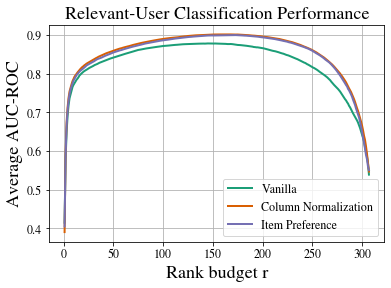

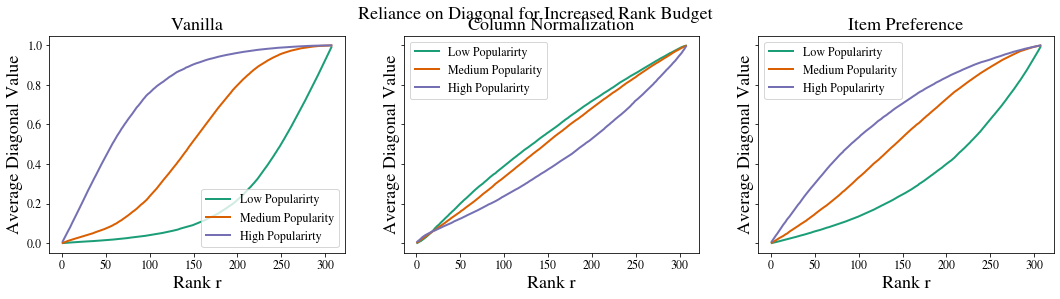

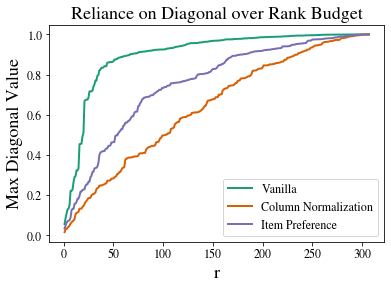

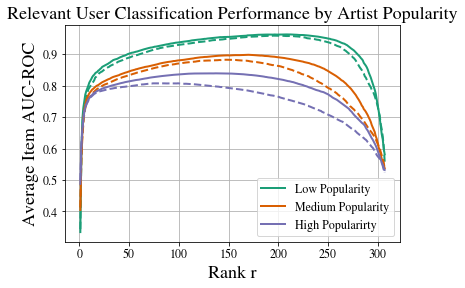

In [34]:
P_train = P[train_idxs]
U, S, Vh = np.linalg.svd(P_train, full_matrices = False)
d = P.shape[1] # should equal len(S)

algs = ["Vanilla", "Column Normalization", "Item Preference"]
        
fig_auc, ax_auc = plt.subplots(ncols = len(algs), figsize = (6 * len(algs), 4), sharey = True, sharex = True)
fig_auc.suptitle("Quality of User Classification for 'Unseen' Items")

fig_auc_agg, ax_auc_agg = plt.subplots()
ax_auc_agg.set_title("Relevant-User Classification Performance")
ax_auc_agg.set_xlabel("Rank budget r")
ax_auc_agg.set_ylabel("Average AUC-ROC")

fig_diag, ax_diag = plt.subplots(ncols = len(algs), figsize = (6 * len(algs), 4), sharey = True, sharex = True)
fig_diag.suptitle("Reliance on Diagonal for Increased Rank Budget")

fig_diag_agg, ax_diag_agg = plt.subplots()
ax_diag_agg.set_title("Reliance on Diagonal over Rank Budget")
ax_diag_agg.set_xlabel("r")
ax_diag_agg.set_ylabel("Max Diagonal Value")

max_r = len(S)
# max_r = 217

baseline_rocs = np.zeros((max_r - 1, len(S)))
for alg_idx, alg_name in enumerate(algs):
    rocs = np.zeros((max_r - 1, len(S)))
    diagonals = np.zeros((max_r - 1, len(S)))
    for idx, r in enumerate(range(1, max_r)):
        proj_mtx = np.zeros((d, d))
        if alg_name == "Vanilla":
            proj_mtx = Vh[:r].T @ Vh[:r]
        elif alg_name == "Item Preference":
            w_lq, v_lq = eigsh(proj_matrices_max_pred[r], which = "LM", k = r)
            proj_mtx = v_lq @ v_lq.T 
        elif alg_name == "Column Normalization":
            D = np.diag([1/np.linalg.norm(P_train[:, j]) for j in range(d)])
            _, _, Vh_baseline = np.linalg.svd(P_train @ D, full_matrices = False)
            proj_mtx = Vh_baseline[:r].T @ Vh_baseline[:r]
        elif alg_name == "Column Standardization":
            P_train_standardized = P_train.copy()
            for j in range(P_train.shape[1]):
                P_train_standardized[:, j] -= np.mean(P_train[:, j])
                P_train_standardized[:, j] /= np.linalg.norm(P_train_standardized[:, j])
            _, _, Vh_baseline = np.linalg.svd(P_train_standardized, full_matrices = False)
            proj_mtx = Vh_baseline[:r].T @ Vh_baseline[:r]
            
        diagonals[idx] = np.diagonal(proj_mtx)
        proj_mtx -= np.diag(np.diagonal(proj_mtx))

        P_projected = P @ proj_mtx
        for j in range(P.shape[1]):
            rocs[idx][j] = roc_auc_score(y_true = P[test_idxs, j] > 0,
                                        y_score = P_projected[test_idxs, j])

    #AUC-ROC
    ax_auc[alg_idx].set_title(alg_name)
    ax_auc[alg_idx].set_xlabel("Rank r")
    ax_auc[alg_idx].set_ylabel("Average Item AUC-ROC")

    ax_auc[alg_idx].plot(range(1, max_r), np.mean(rocs[:, low_artist_filter], axis = 1), label = "Low Popularity", c = colors[0], linewidth = 2)
    ax_auc[alg_idx].plot(range(1, max_r), np.mean(rocs[:, med_artist_filter], axis = 1), label = "Medium Popularity", c = colors[1], linewidth = 2)
    ax_auc[alg_idx].plot(range(1, max_r), np.mean(rocs[:, high_artist_filter], axis = 1), label = "High Popularirty", c = colors[2], linewidth = 2)

    ax_auc[alg_idx].legend()
    ax_auc[alg_idx].grid(visible = True)
    
    ax_auc_agg.plot(range(1, max_r), np.mean(rocs, axis = 1), label = alg_name, c = colors[alg_idx], linewidth = 2)
    
    #DIAGONALS
    ax_diag[alg_idx].set_title(alg_name)
    ax_diag[alg_idx].set_xlabel("Rank r")
    ax_diag[alg_idx].set_ylabel("Average Diagonal Value")

    ax_diag[alg_idx].plot(range(1, max_r), np.mean(diagonals[:, low_artist_filter], axis = 1), label = "Low Popularirty", c = colors[0], linewidth = 2)
    ax_diag[alg_idx].plot(range(1, max_r), np.mean(diagonals[:, med_artist_filter], axis = 1), label = "Medium Popularity", c = colors[1], linewidth = 2)
    ax_diag[alg_idx].plot(range(1, max_r), np.mean(diagonals[:, high_artist_filter], axis = 1), label = "High Popularirty", c = colors[2], linewidth = 2)

    ax_diag[alg_idx].legend()
    
    ax_diag_agg.plot(range(1, max_r), np.max(diagonals, axis = 1), label = alg_name, c = colors[alg_idx], linewidth = 2)
    
    if alg_name == "Vanilla":
        baseline_rocs = rocs.copy()
        
    if alg_name == "Item Preference":
        fig_max_pred, ax_max_pred = plt.subplots()

        ax_max_pred.plot(range(1, max_r), np.mean(rocs[:, low_artist_filter], axis = 1), label = "Low Popularity", c = colors[0], linewidth = 2)
        ax_max_pred.plot(range(1, max_r), np.mean(baseline_rocs[:, low_artist_filter], axis = 1), c = colors[0], linewidth = 2, linestyle = "--")

        ax_max_pred.plot(range(1, max_r), np.mean(rocs[:, med_artist_filter], axis = 1), label = "Medium Popularity", c = colors[1], linewidth = 2)
        ax_max_pred.plot(range(1, max_r), np.mean(baseline_rocs[:, med_artist_filter], axis = 1), c = colors[1], linewidth = 2, linestyle = "--")

        ax_max_pred.plot(range(1, max_r), np.mean(rocs[:, high_artist_filter], axis = 1), label = "High Popularirty", c = colors[2], linewidth = 2)
        ax_max_pred.plot(range(1, max_r), np.mean(baseline_rocs[:, high_artist_filter], axis = 1), c = colors[2], linewidth = 2, linestyle = "--")

        ax_max_pred.set_xlabel("Rank r")
        ax_max_pred.set_ylabel("Average Item AUC-ROC")
        ax_max_pred.set_title("Relevant User Classification Performance by Artist Popularity")
        
        ax_max_pred.legend()
        ax_max_pred.grid(visible = True)
        
        fig_max_pred.savefig("figs/movielens_auc_roc_by_popularity_all_cosine.pdf", bbox_inches = "tight")
        
ax_auc_agg.legend()
ax_auc_agg.grid(visible = True)

ax_diag_agg.legend()

fig_auc_agg.savefig("figs/movielens_auc_roc_all_cosine.pdf", bbox_inches = "tight")

## Figures 5 and 7

In [ ]:
with open("pickles/max_pred_filter_all_rs_lastfm_cosine.pickle", "rb") as pickleFile:
    description, P, proj_matrices_filter = pickle.load(pickleFile)
    
#UNCOMMENT FOR MOVIELENS
# with open("pickles/max_pred_filter_all_rs_movielens_cosine.pickle", "rb") as pickleFile:
#     description, P, proj_matrices_filter = pickle.load(pickleFile)

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


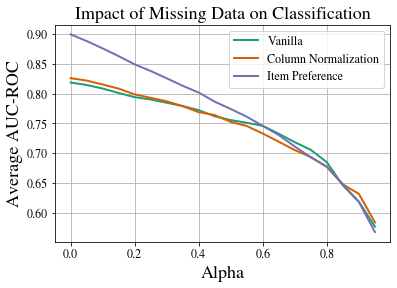

In [41]:
proj_matrices_filter = proj_matrices_filter[106]

def rocs_filtered(alg_name, P, proj_matrices_filter, r):
    '''
        proj_matrices_filter is a dictionary where the key is alpha, the fraction of data entries removed, and the
        values are projection matrices. 
        Returns the average AUC-ROC at each value of alpha.
    '''
    # Move the below into a script file
    rng = np.random.default_rng(2**10)
    nonzero_idxs = np.transpose(np.nonzero(P))
    num_nonzero = len(nonzero_idxs)
    rng.shuffle(nonzero_idxs)

    alphas = list(proj_matrices_filter.keys())
    d = P.shape[1]

    rocs = np.zeros((len(alphas), d))
    for alpha_idx, alpha in enumerate(alphas):
        P_filtered = P.copy()
        for idx in nonzero_idxs[:int(alpha * num_nonzero)]:
            P_filtered[idx[0], idx[1]] = 0

        proj_mtx = np.zeros((d, d))
        if alg_name == "Vanilla":
            U, S, Vh = np.linalg.svd(P_filtered, full_matrices = False)
            proj_mtx = Vh[:r].T @ Vh[:r]
        elif alg_name == "Item Preference":
            w_lq, v_lq = eigsh(proj_matrices_filter[alpha], which = "LM", k = r) #NOTE THIS READS FROM PROJ_MATRICES_FILTER
            proj_mtx = v_lq @ v_lq.T 
        elif alg_name == "Column Normalization":
            D = np.diag([1/np.linalg.norm(P_filtered[:, j]) if np.linalg.norm(P_filtered[:, j]) > 0 else 0 for j in range(d)])
            _, _, Vh_baseline = np.linalg.svd(P_filtered @ D, full_matrices = False)
            proj_mtx = Vh_baseline[:r].T @ Vh_baseline[:r]

        proj_mtx -= np.diag(np.diagonal(proj_mtx))

        P_projected = P @ proj_mtx
        for j in range(P.shape[1]):                
            y_true = P[:, j] > 0
            y_score = P_projected[:, j]
            rocs[alpha_idx][j] = roc_auc_score(y_true = y_true, y_score = y_score)
    return np.mean(rocs, axis = 1)

algs = ["Vanilla", "Column Normalization", "Item Preference"]
    
fig_auc_agg, ax_auc_agg = plt.subplots()
ax_auc_agg.set_title("Impact of Missing Data on Classification")
ax_auc_agg.set_xlabel("Alpha")
ax_auc_agg.set_ylabel("Average AUC-ROC")

r = 106
alphas = list(proj_matrices_filter.keys())
for alg_idx, alg_name in enumerate(algs):
    avg_rocs = rocs_filtered(alg_name, P, proj_matrices_filter, r)
    ax_auc_agg.plot(alphas, avg_rocs, label = alg_name, c = colors[alg_idx], linewidth = 2) 

ax_auc_agg.legend()
ax_auc_agg.grid(visible = True)    
fig_auc_agg.savefig("figs/lastfm_auc_roc_filter_cosine.pdf", bbox_inches = "tight")

100%|██████████| 21/21 [02:37<00:00,  7.51s/it]
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


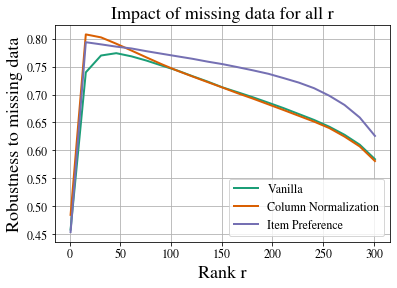

In [44]:
with open("pickles/max_pred_filter_all_rs_lastfm_cosine.pickle", "rb") as pickleFile:
    description, P, proj_matrices_filter = pickle.load(pickleFile)

#UNCOMMENT FOR MOVIELENS
# with open("pickles/max_pred_filter_all_rs_movielens_cosine.pickle", "rb") as pickleFile:
#     description, P, proj_matrices_filter = pickle.load(pickleFile)
    
algs = ["Vanilla", "Column Normalization", "Item Preference"]
    
fig_auc_agg, ax_auc_agg = plt.subplots()
ax_auc_agg.set_title("Impact of missing data for all r")
ax_auc_agg.set_xlabel("Rank r")
ax_auc_agg.set_ylabel("Robustness to missing data")


rs = list(proj_matrices_filter.keys())
for alg_idx, alg_name in enumerate(algs):
    robustness = []
    for r in tqdm(rs):
        avg_rocs = rocs_filtered(alg_name, P, proj_matrices_filter[r], r)
        robustness.append(np.mean(avg_rocs))
    ax_auc_agg.plot(rs, robustness, label = alg_name, c = colors[alg_idx], linewidth = 2) 

ax_auc_agg.legend()
ax_auc_agg.grid(visible = True)    
fig_auc_agg.savefig("figs/lastfm_auc_roc_filter_all_rs_cosine.pdf", bbox_inches = "tight")
